# Part 4: Image Similarity with Hashing

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from src.utils.image_plotting import show_images_from_df, show_similar_images
from getpass import getpass
from cachetools import cached
from snowflake.snowpark.functions import udf
from snowflake.snowpark import types as T
from snowflake.snowpark.files import SnowflakeFile
from PIL import Image
import imagehash

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Creating Snowpark Session
sf_connection = {
    "account": "sfseeurope-prod_demo_gorkow",
    "user": getpass(),
    "password": getpass(),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH"
}
session = Session.builder.configs(sf_connection).create()

In [3]:
# Create a new database
session.sql('CREATE OR REPLACE DATABASE IMAGES').collect()

# Create a Snowflake Stage and enable the Directory Table
session.sql("""CREATE OR REPLACE STAGE IMAGE_FILES
                DIRECTORY = (ENABLE = TRUE AUTO_REFRESH = FALSE) 
                ENCRYPTION = (TYPE = 'SNOWFLAKE_SSE') 
                COMMENT='Stage to store Image Files'""").collect()

# Upload JPG-Files from a local folder to the Snowflake Stage
session.file.put(local_file_name='../resources/image_files/*.jpg',
                 stage_location='@IMAGE_FILES', 
                 auto_compress=False, 
                 overwrite=True)

# Update the Directory Table (can be automated via Snowflake Tasks)
session.sql('ALTER STAGE IMAGE_FILES REFRESH').collect()

[Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image5.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image6.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image7.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image4.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image1.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image2.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-4b76-47c1-88c5-431795a444b8/image3.jpg', status='REGISTERED_NEW', description='File registered successfully.'),
 Row(file='stages/5da5d3ad-

In [4]:
# Create a Snowpark DataFrame for the Directory Table
image_df = session.sql("SELECT * FROM DIRECTORY(@IMAGE_FILES)")
image_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|image1.jpg       |378517  |2023-09-15 00:42:57-07:00  |633c962e26413335b19c2c1defa19e84  |633c962e26413335b19c2c1defa19e84  |https://job14991.snowflakecomputing.com/api/fil...  |
|image2.jpg       |378517  |2023-09-15 00:42:57-07:00  |633c962e26413335b19c2c1defa19e84  |633c962e26413335b19c2c1defa19e84  |https://job14991.snowflakecomputing.com/api/fil...  |
|image3.jpg       |343635  |2023-09-15 00:42:56-07:00  |52a979e11ff5b06bdec9011688d1dcee  |52a979e11

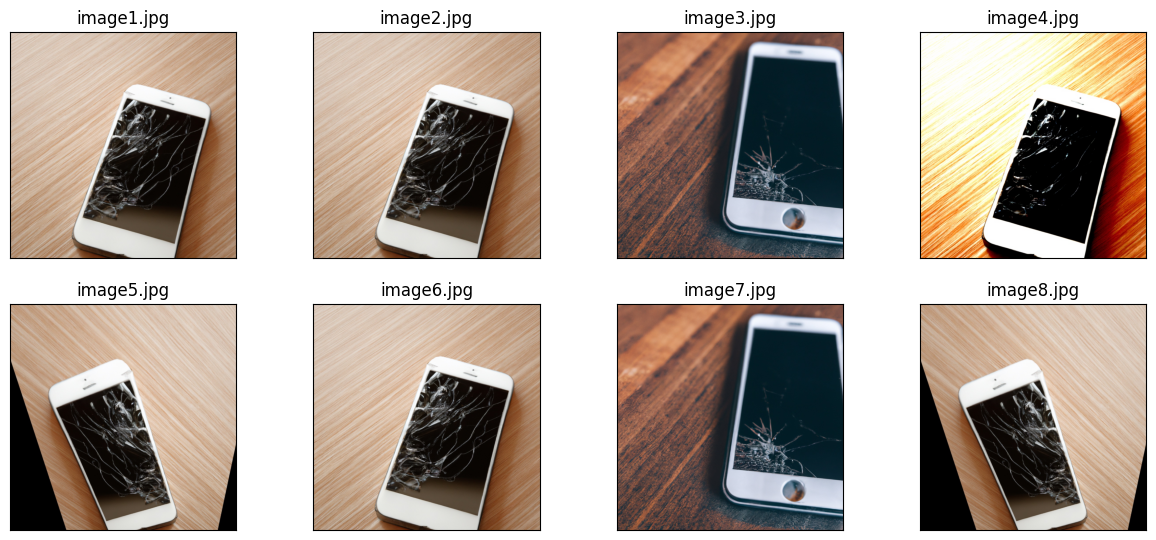

In [5]:
show_images_from_df(image_df, stage='@IMAGE_FILES', ncol=4, figsize=(15,10))

In [6]:
# Create a Snowflake stage to store the functions
session.sql('CREATE STAGE IF NOT EXISTS FUNCTIONS').collect()

# Calculates Average Hashes using imagehash library
@udf(name='GENERATE_IMAGE_HASH', 
     is_permanent=True, 
     stage_location='@FUNCTIONS', 
     replace=True, 
     packages=['snowflake-snowpark-python','pillow','imagehash'])
def generate_image_hash(file: str) -> str:
    with SnowflakeFile.open(file, 'rb') as f:
        return imagehash.average_hash(Image.open(f))
    
# Calculates Hamming Distance between two hashes
@udf(name='CALCULATE_HASH_DISTANCE', 
     is_permanent=True, 
     stage_location='@FUNCTIONS', 
     replace=True, 
     packages=['imagehash'])
def calculate_hash_distance(hash1: str, hash2: str) -> int:
    distance = imagehash.hex_to_hash(hash1)-imagehash.hex_to_hash(hash2)
    return distance

The version of package 'snowflake-snowpark-python' in the local environment is 1.7.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'pillow' in the local environment is 9.5.0, which does not fit the criteria for the requirement 'pillow'. Your UDF might not work when the package version is different between the server and your local environment.


In [7]:
# Create a scoped URL for secure dynamic file access 
image_hashes_df = image_df.with_column('SCOPED_URL', F.call_builtin('BUILD_SCOPED_FILE_URL', F.lit('@IMAGE_FILES'), F.col('RELATIVE_PATH')))

# Create Hashes for Images
image_hashes_df = image_hashes_df.with_column('IMAGE_HASH', generate_image_hash("SCOPED_URL"))

# Persist Hashes
image_hashes_df.write.save_as_table('IMAGE_HASHES', mode='overwrite')
image_hashes_df = session.table('IMAGE_HASHES')

# Display Hashes
image_hashes_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"  |"SIZE"  |"LAST_MODIFIED"            |"MD5"                             |"ETAG"                            |"FILE_URL"                                          |"SCOPED_URL"                                        |"IMAGE_HASH"      |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|image1.jpg       |378517  |2023-09-15 00:42:57-07:00  |633c962e26413335b19c2c1defa19e84  |633c962e26413335b19c2c1defa19e84  |https://job14991.snowflakecomputing.com/api/fil...  |https://job14991.snowflakecomputing.com/api/fil...  |fffffff0e0e0

In [8]:
# Cross Join to generate all combinations
images_hashed_df_cross = image_hashes_df.cross_join(image_hashes_df, lsuffix='_LEFT', rsuffix='_RIGHT')

# Remove joins with self
images_hashed_df_cross = images_hashed_df_cross.filter(F.col('RELATIVE_PATH_LEFT') != F.col('RELATIVE_PATH_RIGHT'))

# Calculate the Hamming-Distance via UDF
images_hashed_df_cross = images_hashed_df_cross.with_column('HAMMING_DISTANCE', calculate_hash_distance('IMAGE_HASH_LEFT', 'IMAGE_HASH_RIGHT'))

# Filter for distances smaller than 5
images_hashed_df_cross = images_hashed_df_cross.filter(F.col('HAMMING_DISTANCE') < 5)

# Sorting values
images_hashed_df_cross = images_hashed_df_cross.order_by(F.col('RELATIVE_PATH_LEFT'),F.col('HAMMING_DISTANCE'))['RELATIVE_PATH_LEFT','RELATIVE_PATH_RIGHT','HAMMING_DISTANCE']

# Display similar images
images_hashed_df_cross.show()

---------------------------------------------------------------------
|"RELATIVE_PATH_LEFT"  |"RELATIVE_PATH_RIGHT"  |"HAMMING_DISTANCE"  |
---------------------------------------------------------------------
|image1.jpg            |image6.jpg             |0                   |
|image1.jpg            |image2.jpg             |0                   |
|image1.jpg            |image4.jpg             |1                   |
|image2.jpg            |image6.jpg             |0                   |
|image2.jpg            |image1.jpg             |0                   |
|image2.jpg            |image4.jpg             |1                   |
|image3.jpg            |image7.jpg             |0                   |
|image4.jpg            |image1.jpg             |1                   |
|image4.jpg            |image2.jpg             |1                   |
|image4.jpg            |image6.jpg             |1                   |
---------------------------------------------------------------------



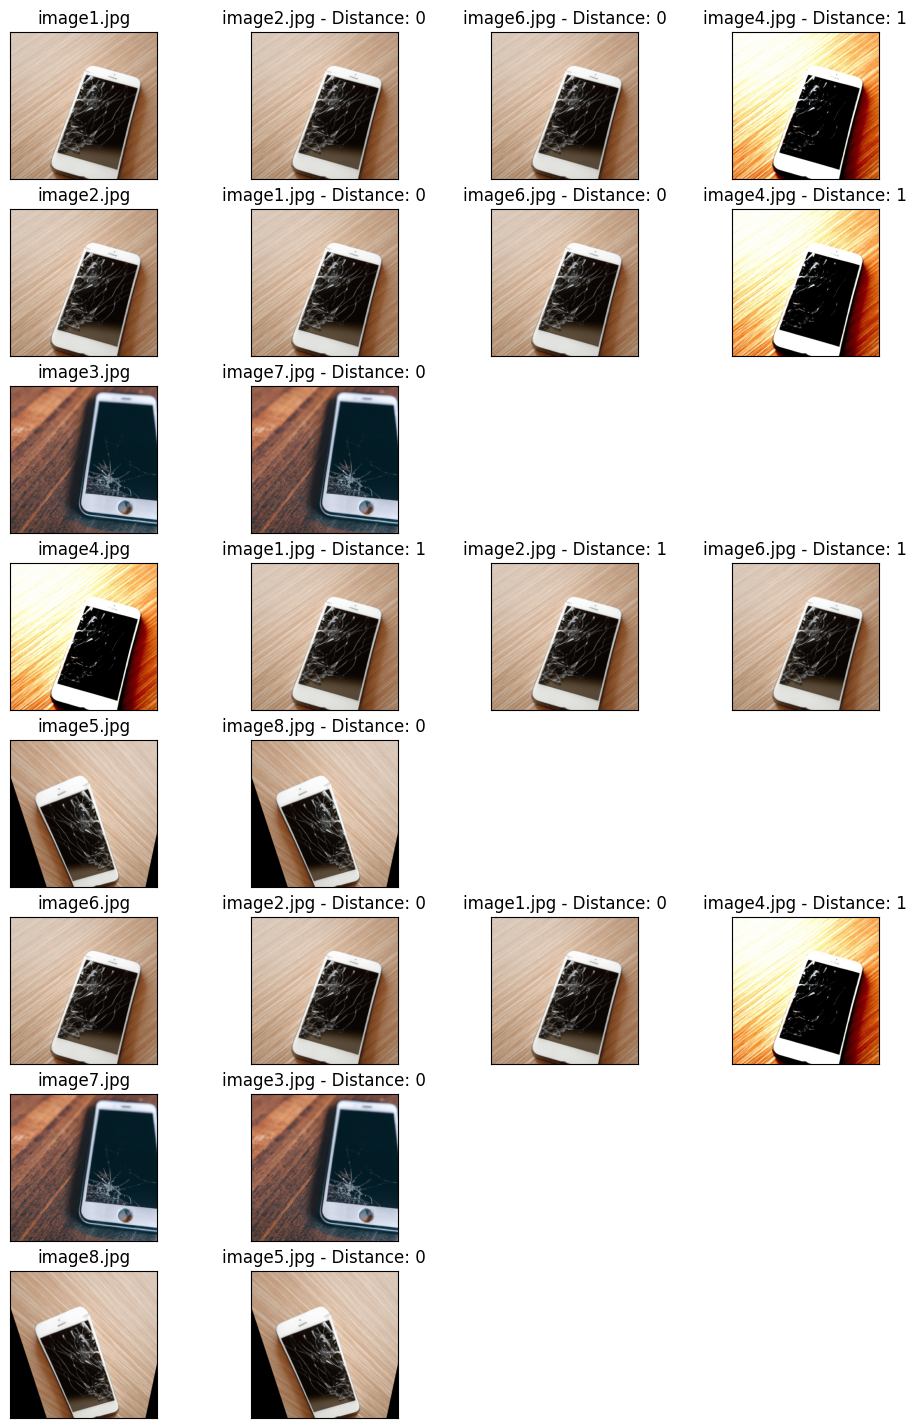

In [9]:
show_similar_images(
    df=images_hashed_df_cross, 
    stage='@IMAGE_FILES', 
    distance_col='HAMMING_DISTANCE', 
    figsize=(15,18), 
    max_similar_images=4
    )